# Convolutional Neural Networks

In this tutorial we continue our journey in deep learning by looking at convolutional neural networks or ConvNets.

In [77]:
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt, cm

## Understanding convolutions

In thisfirst section, we experiment convolutions on images using simple `numpy` operations. We first work with a single channel image from MNIST and then a 3 channel RGB image of a cat.

In [4]:
from sklearn.datasets import load_digits
mnist = load_digits()

create a variable `image` to hold the first $8\times8$ image in the data set

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


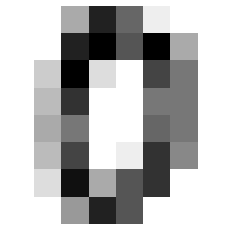

In [5]:
image = mnist['images'][0]
print(image)
plt.imshow(image, cmap=cm.gray_r)
plt.axis('off')
plt.show()

create the following $3\times 3$ kernel as a numpy array: $\left[\begin{array}{ccc}-1 & 0 & +1 \\ -2 & 0 & +2 \\ -1 & 0 & +1\end{array}\right]$

In [6]:
kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
print(kernel)

[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]


pad the image with zeros.

In [7]:
kernel_size = kernel.shape[0]
pad = (kernel_size - 1) // 2
im = np.pad(image, ((pad, pad), (pad, pad)), mode='constant')
print('paded image size is now {}'.format(im.shape))

paded image size is now (10, 10)


convolve the kernel with the image. Create an algorithm using for loops to output the convolution to a new variable `conv`.

output size of the convolution is (8, 8)


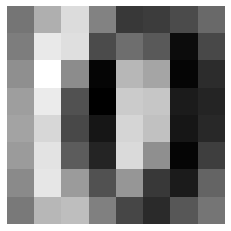

In [8]:
conv = np.empty_like(image)

for i in range(pad, im.shape[0] - pad):
    for j in range(pad, im.shape[1] - pad):
        subset = im[i-pad:i+pad+1, j-pad:j+pad+1]
        conv[i-pad, j-pad] = np.dot(kernel.ravel(), subset.ravel())  # element-wise multiplication

print('output size of the convolution is {}'.format(conv.shape))
plt.imshow(conv, cmap=cm.gray)
plt.axis('off')
plt.show()

now this works, make a function called `convolve` which takes for input an image, a kernel and output the result of the convolution. Assume image is in form (n x m x channels) and represented by floats in the [0, 1] range.

In [9]:
def convolve(image, kernel):
    kernel_size = kernel.shape[0]
    pad = (kernel_size - 1) // 2
    im = np.pad(image, ((pad, pad), (pad, pad)), mode='constant')
    conv = np.empty_like(image)

    for i in range(pad, im.shape[0] - pad):
        for j in range(pad, im.shape[1] - pad):
            # get the (i, j) subset of size (2 x pad + 1)
            subset = im[i - pad:i + pad + 1, j - pad:j + pad + 1]
            # perform the convolution
            conv[i - pad, j - pad] = (subset * kernel).sum()
    conv = (conv - conv.min()) / (conv.max() - conv.min())  # normalization
    return conv

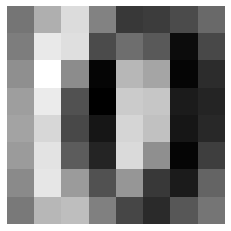

In [12]:
plt.imshow(convolve(image, kernel), cmap=cm.gray)
plt.axis('off')
plt.show()

Now let's work with a 3 channel RGB image. Load it, convert if to float representation and in gray scale mode.

In [13]:
from skimage import data
cat = data.chelsea().astype(np.float)
cat = np.mean(cat, axis=2)  # convert to gray scale
cat /= cat.max()  # with float representation, the range is [0, 1]
print(cat.shape)
print(cat.dtype)
print(cat.max())

(300, 451)
float64
1.0


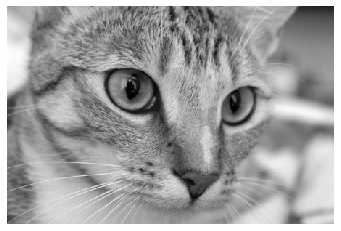

In [14]:
plt.imshow(cat, cmap=cm.gray)
plt.axis('off')
plt.show()

create all the following kernel and try them out:

 - Blur kernel: $\left[\begin{array}{ccc}1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1\end{array}\right]$
 - Laplacian kernel: $\left[\begin{array}{ccc}0 & 1 & 0 \\ 1 & -4 & 1 \\ 0 & 1 & 0\end{array}\right]$
 - Emboss kernel: $\left[\begin{array}{ccc}-2 & -1 & 0 \\ -1 & 1 & 1 \\ 0 & 1 & 2\end{array}\right]$

In [15]:
# blur filters
blur3 = np.array(([1, 1, 1], [1, 1, 1], [1, 1, 1]))
blur5 = np.ones((5, 5))
blur7 = np.ones((7, 7))

# sharpen
sharpen = np.array(([0, -1, 0], [-1, 5, -1], [0, -1, 0]))

# Laplacian kernel
laplacian = np.array(([0, 1, 0], [1, -4, 1], [0, 1, 0]))

# construct the Sobel x-axis kernel
sobelX = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]))

# construct the Sobel y-axis kernel
sobelY = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]))

# construct an emboss kernel
emboss = np.array(([-2, -1, 0], [-1, 1, 1], [0, 1, 2]))

kernels = [blur3, sharpen, laplacian, emboss]
kernel_labels = ['blur3', 'sharpen', 'laplacian', 'emboss']

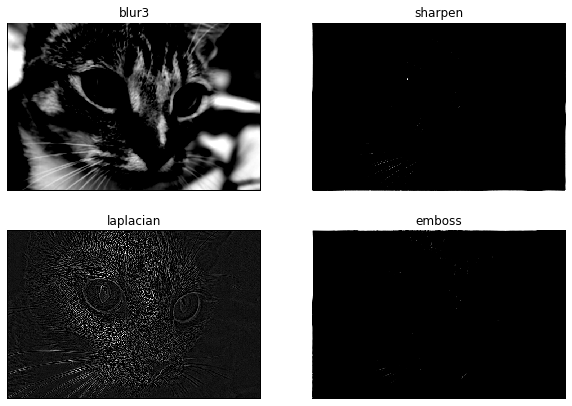

In [16]:
fig = plt.figure(figsize=(10, 7))
for i in range(len(kernels)):
    ax = plt.subplot(2, 2, i + 1)
    convolution = convolve(cat, kernels[i])
    plt.imshow(convolution, cmap=cm.gray, vmin=0.6, vmax=0.9)
    plt.title(kernel_labels[i])
    plt.axis('off')
plt.show()

## Our First ConvNet: ShallowNet architecture

This model only contains a few layers, so it is perfect to get started with CNN. The architecture can be summarized as:

```INPUT => CONV => RELU => FC```

### As usual start by loading our data set

Here we will work with animals JPG pictures with 3 classes: cats, dogs and panda

In [28]:
labels = ['cats', 'dogs', 'panda']
data = np.load('animals.npz')
print(data['X'].shape)
print(data['y'].shape)

(3000, 32, 32, 3)
(3000,)


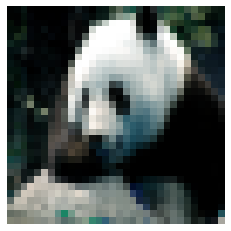

In [18]:
plt.imshow(data['X'][np.random.randint(3000)])
plt.axis('off')
plt.show()

Partition the data into training and testing splits using 75% of the data for training and the remaining 25% for testing


In [19]:
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(data['X'], data['y'], test_size=0.25, random_state=42)

Convert the labels from integers to vectors

In [20]:
from sklearn.preprocessing import LabelBinarizer

y_train = LabelBinarizer().fit_transform(y_train)
y_test = LabelBinarizer().fit_transform(y_test)

In [21]:
# some sanity checks
print(y_train.dtype)
print(X_test[0].shape)
print(y_train[0])
print(y_test[1])

int64
(32, 32, 3)
[0 0 1]
[1 0 0]


### Build the model with Keras

start importing useful stuff from Keras

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

Initialize the optimizer and model

In [23]:
model = Sequential()
# define the first (and only) CONV => RELU layer
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
# softmax classifier after a FC layer
model.add(Flatten())
model.add(Dense(3))
model.add(Activation('softmax'))

In [24]:
from tensorflow.keras.optimizers import SGD
print('compiling model')
opt = SGD(lr=0.005)
model.compile(
    loss='categorical_crossentropy', 
    optimizer=opt, 
    metrics=['accuracy'])

compiling model


Train the network using 100 epochs and a mini batch size of 32.

In [25]:
print('training network')
H = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    batch_size=32, 
    epochs=100, 
    verbose=1)

training network
Train on 2250 samples, validate on 750 samples
Epoch 1/100
2250/2250 [==============================] - 3s 1ms/sample - loss: 1.0142 - accuracy: 0.4671 - val_loss: 1.0635 - val_accuracy: 0.5080
Epoch 2/100
2250/2250 [==============================] - 2s 703us/sample - loss: 0.9472 - accuracy: 0.5040 - val_loss: 0.9227 - val_accuracy: 0.5187
Epoch 3/100
2250/2250 [==============================] - 2s 742us/sample - loss: 0.8975 - accuracy: 0.5671 - val_loss: 1.0188 - val_accuracy: 0.4427
Epoch 4/100
2250/2250 [==============================] - 2s 792us/sample - loss: 0.8799 - accuracy: 0.5756 - val_loss: 0.9077 - val_accuracy: 0.5267
Epoch 5/100
2250/2250 [==============================] - 2s 711us/sample - loss: 0.8601 - accuracy: 0.5849 - val_loss: 0.8742 - val_accuracy: 0.5347
Epoch 6/100
2250/2250 [==============================] - 2s 702us/sample - loss: 0.8463 - accuracy: 0.5787 - val_loss: 0.8038 - val_accuracy: 0.5920
Epoch 7/100
2250/2250 [=====================

Save our model to the disk (to reuse it later), this is called **serialization**. In Keras, the architecture of the model and the trained weights are save to a HDF5 file.

In [30]:
model.save('my_shallow_cnn.hdf5')

Now evaluate the network

In [26]:
predictions = model.predict(X_test, batch_size=32)

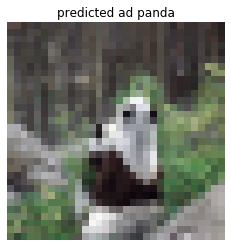

In [29]:
index = 4
plt.imshow(X_test[index])
plt.title('predicted ad %s' % labels[predictions[index].argmax()])
plt.axis('off')
plt.show()

In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labels))

              precision    recall  f1-score   support

        cats       0.53      0.87      0.66       249
        dogs       0.76      0.27      0.40       262
       panda       0.83      0.86      0.84       239

    accuracy                           0.66       750
   macro avg       0.71      0.67      0.63       750
weighted avg       0.71      0.66      0.63       750



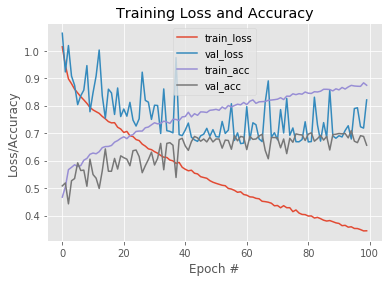

In [33]:
# plot the training loss and accuracy
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

## A Deeper ConvNet for CIFAR-10

Finally for this tutorial we try this a deeper CNN with the rather difficult CIFAR-10 data set. We will see that we can reach > 80% accuracy which is much better that previous attempts we did.

As a side note, with much deeper networks (outside the scope of this tutorial since they need GPu hardware to train), it is *relatively easy* to acheive >90% (and even 95%) precision on this data set.

In [45]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float') / 255.0
X_test = X_test.astype('float') / 255.0
labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'boat', 'truck']

In [46]:
print(X_train[0].shape)

(32, 32, 3)


convert the labels from integers to vectors

In [47]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

Import all the bells and whistles we need from from Keras

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

Initialize the optimizer and model

In [53]:
model = Sequential()

# first CONV => RELU => CONV => RELU => POOL layer set
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# second CONV => RELU => CONV => RELU => POOL layer set
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier for the 10 classes
model.add(Dense(10))
model.add(Activation('softmax'))


Compile our model with SGD + Momentum, crossentropy loss and use accuracy as our metric.

In [54]:
opt = SGD(lr=0.01, decay=0.01 / 40, momentum=0.9, nesterov=True)
model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"])

Train the network using 40 epochs and a mini batch size of 64.

In [55]:
H = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    batch_size=64, 
    epochs=10,  # should go to 40 
    verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 316s 6ms/sample - loss: 1.6621 - accuracy: 0.4445 - val_loss: 1.2616 - val_accuracy: 0.5517
Epoch 2/10
50000/50000 [==============================] - 309s 6ms/sample - loss: 1.1803 - accuracy: 0.5858 - val_loss: 0.9563 - val_accuracy: 0.6686
Epoch 3/10
50000/50000 [==============================] - 319s 6ms/sample - loss: 0.9786 - accuracy: 0.6574 - val_loss: 1.0014 - val_accuracy: 0.6490
Epoch 4/10
50000/50000 [==============================] - 304s 6ms/sample - loss: 0.8640 - accuracy: 0.6979 - val_loss: 0.7737 - val_accuracy: 0.7330
Epoch 5/10
50000/50000 [==============================] - 301s 6ms/sample - loss: 0.7923 - accuracy: 0.7210 - val_loss: 0.7386 - val_accuracy: 0.7388
Epoch 6/10
50000/50000 [==============================] - 316s 6ms/sample - loss: 0.7335 - accuracy: 0.7418 - val_loss: 0.6763 - val_accuracy: 0.7622
Epoch 7/10
50000/50000 [==========================

Save our trained model to the disk.

In [59]:
model.save('miniVGGnet_cifar10.hdf5')

Now evaluate the model.

In [56]:
predictions = model.predict(X_test, batch_size=64)

In [57]:
from sklearn.metrics import classification_report

print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labels))

              precision    recall  f1-score   support

       plane       0.83      0.75      0.79      1000
         car       0.91      0.87      0.89      1000
        bird       0.76      0.64      0.69      1000
         cat       0.61      0.63      0.62      1000
        deer       0.77      0.73      0.75      1000
         dog       0.65      0.71      0.68      1000
        frog       0.79      0.89      0.84      1000
       horse       0.85      0.81      0.83      1000
        boat       0.83      0.92      0.87      1000
       truck       0.86      0.89      0.87      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



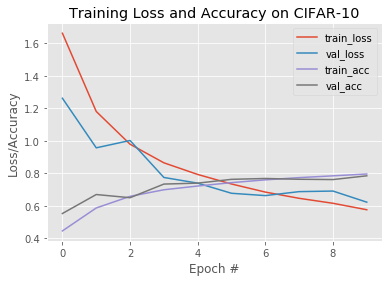

In [58]:
# plot the training loss and accuracy
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title('Training Loss and Accuracy on CIFAR-10')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

Finally label a few images with their prediction

In [83]:
N = 8
M = 4
indices = np.random.randint(0, y_test.shape[0], size=N*M)

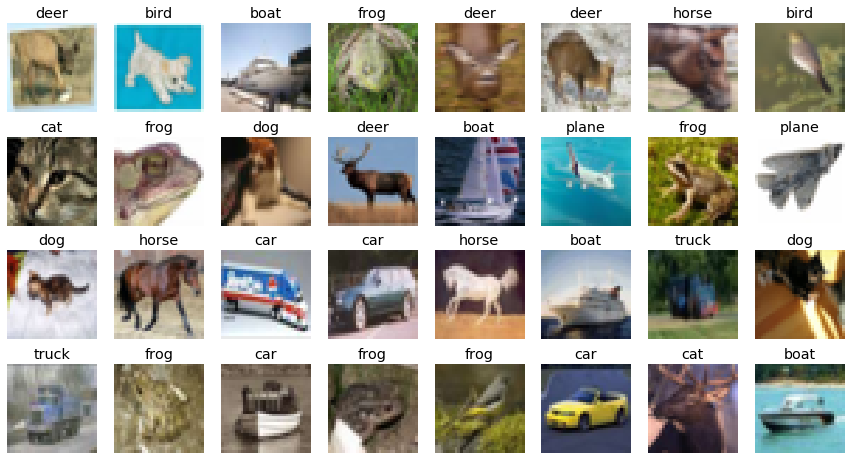

In [84]:
plt.figure(figsize=(15, 8))
for i in range(N * M):
    ax = plt.subplot(M, N, i + 1)
    plt.imshow(X_test[indices[i]])
    plt.axis('off')
    plt.title('%s' % labels[predictions[indices[i]].argmax()])
plt.show()